# Dependencies

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.io import loadmat
from MP import progress_bar
from glob import glob
import pandas as pd
import time,os
from matplotlib import gridspec
gs=gridspec.GridSpec
uet=progress_bar.update_elapsed_time

from MP.lib import mpl_lib
from MP.lib.mpl_lib import rm_all_lab as ral
from MP.lib.mpl_lib import tune_xy_lim as txl
from matplotlib.colors import LogNorm

from MP.mat import mech

- Current work direction 

In [3]:
pwd

u'/Users/yj/repo/FLD_DIC_XRAY/tutorials/DIC_analysis/IF_steel/BB'

- Available files

In [4]:
ls -l /Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/BB/20141028/DIC

total 235144
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0000_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0001_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0002_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0003_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0004_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0005_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0006_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0007_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0008_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0009_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0011_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0012_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0013_0.mat*
-rwxr-xr-x  1 yj  admin  5469129 Mar 30 14:51 BB_IFsteel-0014_0.mat*
-rwxr-xr-x  1 yj  adm

- Pick a file name ( each file corresponds to single snapshot)

In [5]:
fn_start='/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/BB/20141028/DIC/BB_IFsteel-00??_0.mat'
fns=glob(fn_start)
for fn in fns:
    #print fn
    if not(os.path.isfile(fn)):
        raise IOError, '%s is not loadable'%fn

- Load the file and measure the file loading time

In [6]:
t0=time.time()
dat_raw=[]
dic_ind=[]
for i in xrange(len(fns)):
    fn =fns[i]
    dum=os.path.split(fn)[-1].split('.mat')[0][::-1]
    dum = dum[:6][::-1]
    ind=int(dum[:4:])
    # print fn,ind
    dic_ind.append(ind)
    dat_dict=loadmat(fn)
    dat_raw.append(dat_dict)
    if mod(i,10)==0: uet(time.time()-t0,head='loading time:')

loading time:: 660 [ ms]

- Variables available in each file

In [7]:
print dat_raw[0].keys()

['q_ref', 'dV_dt', 'X', 'dExx_dt', 'dEyy_dt', 'eyy', 'r_ref', 'e_vonmises', 'e3_dot', 'U', 'W', 'V', 'Y', 'dU_dt', 'Z', 'e1', 'e3', 'e2', 'dExy_dt', 'q', 'r', 'u', 'exx', 'v', 'y', 'x', 'dW_dt', 'sigma', 'gamma', 'exy']


In [8]:
nstp = len(dat_raw)
nx,ny = dat_raw[-1]['sigma'].shape
print 'Total number of steps (# of DIC snapshots):', nstp
print '2D resolution (nx,ny):', nx,ny,'nx*ny:',nx*ny

Total number of steps (# of DIC snapshots): 22
2D resolution (nx,ny): 186 245 nx*ny: 45570


# Comparison between unfiltered raw data and data filtered by $\sigma$ 

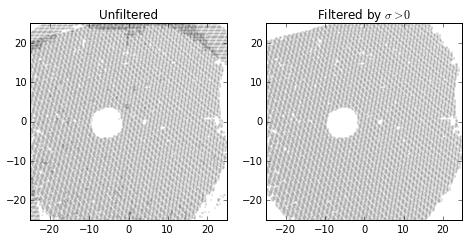

In [9]:
fig=plt.figure(121,figsize=(8,4))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.scatter(dat_raw[-1]['X'],dat_raw[-1]['Y'],marker='.',s=0.05)
ax1.set_xlim(-25,25);ax1.set_ylim(-25,25)
ax1.set_aspect('equal');ax1.set_title('Unfiltered')

ax2.scatter(dat_raw[-1]['X'][dat_raw[-1]['sigma']>0],dat_raw[-1]['Y'][dat_raw[-1]['sigma']>0],marker='.',s=0.05)
ax2.set_xlim(-25,25);ax2.set_ylim(-25,25)
ax2.set_aspect('equal');ax2.set_title(r'Filtered by $\sigma>0$')

# Define necessary functions

In [10]:
"""
Find minimum or maximum discarding +- inp and nan
"""
def find_mx(a):
    mx=None
    for i in xrange(len(a)):
        if ((a[i]>mx and a[i]!=np.inf) or mx==None) and not(np.isnan(a[i])): mx=a[i]
    return mx

def find_mn(a):
    mn=None
    for i in xrange(len(a)):
        if ((a[i]<mn and a[i]!=-np.inf) or mn==None) and not(np.isnan(a[i])): mn=a[i]
    return mn

def find_mxmn(*args):
    """
    Return max and min
    """
    maxs, mns=[], []
    for a in args:
        mns.append(find_mn(a))
        mxs.append(find_mx(a))
    return mxs, mns

## Contruct a normalized spectrum of color
def make_cb(dat,mn=None,mx=None,log=False):
    """
    Arguments
    =========
    dat
    mn  = None
    mx  = None
    log = False (If True, use LogNorm)
    """
    array = dat.flatten()
    if mn==None: mn = find_mn(array) 
    if mx==None: mx = find_mx(array)
    if log: norm=LogNorm(vmin=mn,vmax=mx)
    else:   norm=mpl.colors.Normalize(vmin=mn,vmax=mx)
    cmap,m = mpl_lib.norm_cmap(mn=mn,mx=mx,cm_name='jet')
    return cmap, norm, m

- Data masking bases on $\sigma$ values - those elements with $\sigma>0.$

In [11]:
#np.maskdat_raw[0]['q_ref']
t0=time.time()
iplot=False

for istp in xrange(nstp):
    dum=dat_raw[istp]['sigma'][dat_raw[istp]['sigma']>0]
    if iplot: plot(dum.flatten(),'x')
    if iplot: uet(time.time()-t0,head='plotting time:')
uet(time.time()-t0,head='Total time elapsed')

Total time elapsed:  41 [ ms]

- Test dat_mask can easily mask unwanted data based on its 'key' from the dictionary raw data "dat_raw" array.

key:"e3" 
-----------


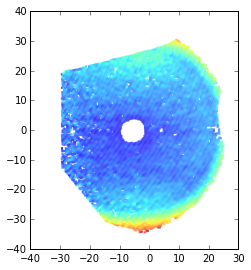

In [12]:
def dat_mask(dat_raw,istp,*keys):
    """
    From dat_raw, mask the data
    that have its corresponding 'sigma' value 
    lower than zero.
    
    Also, return masked data for the given step.
    """
    d=[]
    k=0
    for key in keys:
        # if k==0:print np.array(dat_raw[istp][key]).shape
        array = dat_raw[istp][key]
        sigma = dat_raw[istp]['sigma']
        array = array[sigma>0]
        d.append(array)        
        k=k+1
    return d


## --
key='exx'
key='dExx_dt'
key='e3'
print 'key:"%s"'%key,'\n-----------'
for istp in xrange(nstp):
    x, y, z = dat_mask(dat_raw,istp,'X','Y',key)
    mx, mn  = find_mx(z), find_mn(z)
    #if istp==0: print '%5s %5s'%('min','max')
    #print '%5.3f %5.3f'%(mn, mx)

cmap, norm, m = make_cb(z,mn=mn,mx=mx)
C=m.to_rgba(z)
scatter(x,y,color=C,marker='.',s=0.3)
plt.gca().set_aspect('equal')

# PLOT XY(Z)

nx 25770


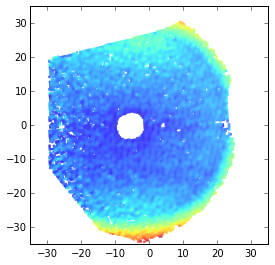

In [13]:
istp=-1
keys = 'e_vonmises'
X,Y,Z = dat_mask(dat_raw, istp, 'X','Y',key)  ## premasked array by 'sigma'
mn,mx=find_mn(Z),find_mx(Z)
cmap,norm,m = make_cb(dat=Z,mn=mn,mx=mx)

nx,= X.shape
print 'nx',nx
cs=[];X_=[];Y_=[];

c = m.to_rgba(Z)
plt.scatter(X,Y,marker='.',color=c,s=0.5)#,s=0.05)
plt.gca().set_xlim(-35,35); plt.gca().set_ylim(-35,35)
plt.gca().set_aspect('equal')

In [14]:
"""
Keys in the dictionary file:
----------------------------
'q_ref', 'dV_dt', 'X', 'dExx_dt', 'dEyy_dt', 'eyy', 'r_ref', 'e_vonmises', 'e3_dot', 'U', 'W', 'V', 'Y', 'dU_dt',
'Z', 'e1', 'e3', 'e2', 'dExy_dt', 'q', 'r', 'u', 'exx', 'v', 'y', 'x', 'dW_dt', 'sigma', 'gamma', 'exy'
"""
t0=time.time()
key = 'e_vonmises'

nc=int(sqrt(nstp))+1
nr=nstp/nc; nr = nr + 1
print nc,nr

if nc*nr<nstp: raise IOError, 'Insufficient cells'
g=gs(nc*10,(nr+1)*10,hspace=0,wspace=0)

ux=2;uy=2

## Switch for plotting
### ---------------------------------------------------------------
iplot=False
### ---------------------------------------------------------------
if iplot: fig=plt.figure(figsize=((nr+1)*ux,nc*uy))

mns=[];mxs=[]
for istp in xrange(nstp):
    Z, = dat_mask(dat_raw,istp,key)
    mn, mx = find_mn(Z),find_mx(Z)
    mns.append(mn); mxs.append(mx)
    uet(time.time()-t0,head='Elapsed time for finding max and min:')
mn,mx = find_mn(mns), find_mx(mxs)
print
print 'minimum and maximum',mn, mx

if iplot:
    norm = mpl.colors.Normalize(vmin=mn,vmax=mx)
    cmap, m = mpl_lib.norm_cmap(mn=mn,mx=mx)




k = 0; axes = []
t0=time.time()
for i in xrange(nc):
    for j in xrange(nr):
        if iplot:
            ax=fig.add_subplot(g[i*10:(i+1)*10,j*10:(j+1)*10])
            ax.set_aspect('equal')
            ax.minorticks_on()
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.tick_params(axis='both', which='minor', labelsize=8)

        x,y,z=dat_mask(dat_raw,k,'X','Y',key)
        if iplot:
            cs=m.to_rgba(z)
            ax.scatter(x,y,marker='.',color=cs,s=0.02)
            ax.set_xlim(-35,35);ax.set_ylim(-35,35)
            ax.locator_params(nbins=4)
            ax.text(x=0.8,y=0.9,s='# %i'%k,verticalalignment='center',
                    horizontalalignment='center',
                    fontsize=12,transform=ax.transAxes)
        k=k+1
        if i==nc-1 and j==0:
            if iplot:
                ax.set_xlabel('X [mm]',dict(fontsize=15))
                ax.set_ylabel('Y [mm]',dict(fontsize=15))
        else: 
            if iplot:
                axes.append(ax)
        if iplot: uet(time.time()-t0,head='Elapsed time for plotting:')
        else: uet(time.time()-t0,head='Elapsed time for data masking')
        if k>=nstp: break
    if k>=nstp: break

if iplot:
    txl(fig.axes)        
    ral(axes)

    axcb=fig.add_subplot(g[(nc-1)*10:(nc)*10,(nr)*10+1:(nr)*10+2])
    mpl_lib.add_cb(ax=axcb,cmap=cmap, filled=True,
                   format='%5.3f',norm=norm,
                   ylab=r'%s '%key)

uet(time.time()-t0,head='Elapsed time:')

5 5
Elapsed time for finding max and min:: 638 [ ms]
minimum and maximum 1.53611e-18 0.418276
Elapsed time::  40 [ ms]

- Reduce data set by area

## -- As a first approximation, get an average with an small area

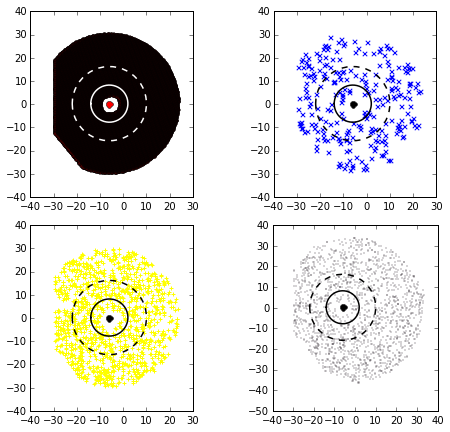

In [15]:
def r_area(x,y,rad,x0,y0,*args):
    """
    Reduce the data by its radius
    """
    x,y = x-x0,y-y0
    r = np.sqrt(x**2+y**2)
    zs=[]
    for arg in args:
        zs.append(arg[r<rad])
    return zs

def rr(x,y,rad,x0,y0,p,*args):
    #print len(x) ,' ->',
    zs=r_area(x,y,rad,x0,y0,*args)
    #print len(zs[0]), '->',
    
    if p<0: return zs
    elif p>0 and p<1: 
        #print len(zs[0])
        n = int(len(zs[0])*p)
        #print n
    elif p==1:
        return zs

    slc = random.choice(len(zs[0]),n)
    Z=[]
    for i in range(len(zs)):
        Z.append(zs[i][slc])
    return Z

def stat(dat):
    return np.average(dat), np.std(dat)
    

 
## application
key = 'e_vonmises'
x_,y_,z_=dat_mask(dat_raw,0,'X','Y',key)

## masking by 'area' and extract from only a portion of total data
fig=plt.figure(figsize=(7,9))
ax1=fig.add_subplot(323)
ax2=fig.add_subplot(324)
ax3=fig.add_subplot(325)
ax4=fig.add_subplot(326)

## for BB
x0=-6.0; y0=0.2;
rad_washer=16.
rad=8.

x,y,z = rr(x_,y_,30,x0,y0,1,x_,y_,z_)
ax1.scatter(x,y,marker='.',c='red')
x,y,z = rr(x_,y_,30,x0,y0,0.01,x_,y_,z_)
ax2.scatter(x,y,marker='x',c='blue')
x,y,z = rr(x_,y_,30,x0,y0,0.05,x_,y_,z_)
ax3.scatter(x,y,marker='+',c='yellow')
x,y,z = rr(x_,y_,40,x0,y0,0.05,x_,y_,z_)
ax4.scatter(x,y,marker='o',c='magenta',s=0.04)

## Trace of window of the washer
thw=np.linspace(-pi,pi)
xw=np.cos(thw)*rad_washer+x0
yw=np.sin(thw)*rad_washer+y0
xa=np.cos(thw)*rad+x0
ya=np.sin(thw)*rad+y0

ax1.plot(x0,y0,'ro')
ax1.plot(xw,yw,'w--')
ax1.plot(xa,ya,'w-')

for ax in fig.axes[1:]:
    ax.plot(x0,y0,'ko')
    ax.plot(xw,yw,'k--')
    ax.plot(xa,ya,'k-')
for ax in fig.axes:
    ax.set_aspect('equal')
plt.tight_layout()


In [16]:
path=os.path.split(fn_start)[0]
fn=os.path.join(path,'DIC_results.txt')
print fn
f=open(fn,'w')

keys=['e1','e2','exx','eyy','exy','sigma']
evm = []
for istp in xrange(nstp):
    if istp==0: 
        f.write('%4s '%'DIC')
        for key in keys:
            f.write('%8s_A %8s_E '%(key,key))
        f.write('\n')
    f.write('%4.4i '%dic_ind[istp])
    for key in keys:
        x, y, z= dat_mask(dat_raw,istp,'X','Y',key)
        zr = rr(x,y,rad,x0,y0,-1,z)
        avg,std= stat(zr)
        f.write(('%+9.3e '*2)%(avg, std))
    f.write('\n')
f.close()
st=os.popen('head -n 3 %s'%fn).read()
print st

/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/BB/20141028/DIC/DIC_results.txt
 DIC       e1_A       e1_E       e2_A       e2_E      exx_A      exx_E      eyy_A      eyy_E      exy_A      exy_E    sigma_A    sigma_E 
0000 +5.812e-04 +4.994e-04 -4.315e-04 +4.849e-04 +1.176e-04 +6.262e-04 +3.211e-05 +3.866e-04 -1.432e-04 +4.534e-04 +9.443e-03 +8.467e-04 
0001 +6.449e-04 +5.718e-04 -4.602e-04 +5.004e-04 +1.141e-04 +8.108e-04 +7.061e-05 +3.667e-04 +3.512e-05 +4.432e-04 +9.327e-03 +8.364e-04 

